# Digit Recognition using support vector machine
## Getting, loading and exploring the data

- Explore the data briefly

In [1]:
!head train.csv

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from pylab import *
import random
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as ss
import sqlite3

In [3]:
pd.read_csv?

In [4]:
train=pd.read_csv("train.csv",header=0,nrows=42000)

- Look at the data

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.shape

(42000, 785)

- Divide pixel data and labels, and also divide training set and cv set

In [7]:
labels=train.iloc[:,0]
pixels=train.iloc[:,1:]

In [8]:
tts?


In [9]:
training,cv,training_label,cv_label=tts(pixels,labels,test_size=0.2,random_state=0)

In [13]:
type(training)

pandas.core.frame.DataFrame

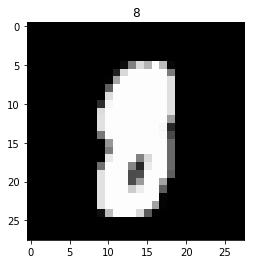

In [10]:
def loadimage(training,training_label,i):
    img=training.iloc[i].as_matrix()
    img=img.reshape(28,28)
    plt.imshow(img,cmap='gray')
    plt.title(training_label.iloc[i])
    plt.show()
loadimage(training,training_label,3359)

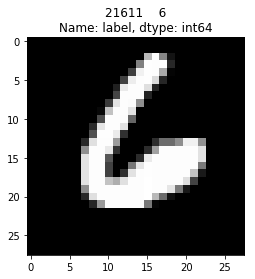

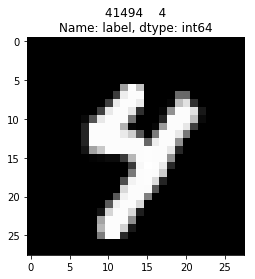

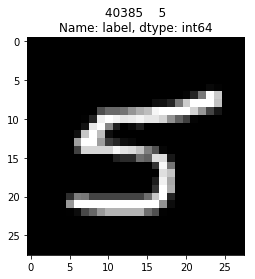

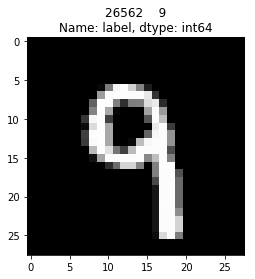

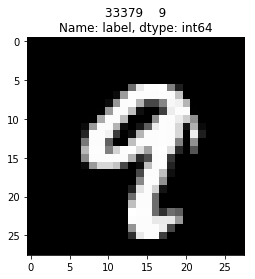

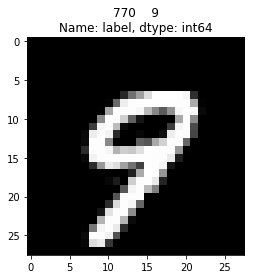

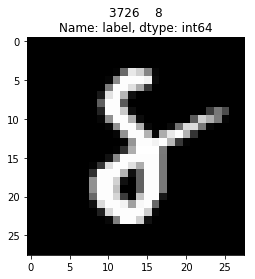

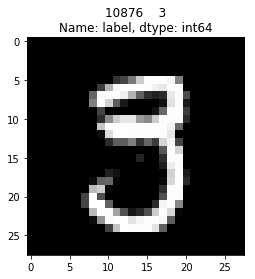

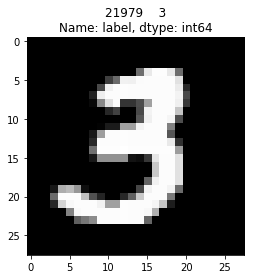

In [11]:
a=list(range(1,33600))
for i in range(9):
    id=random.sample(a,1)
    loadimage(training,training_label,id)

- Run SVM directly costs a lot of time ,let do dimensioality reduction first

In [12]:
pca=PCA(n_components=90,whiten=True)
pca.fit(training)
training_r=pca.transform(training)
pca.explained_variance_ratio_.sum()

0.9039564852121863

In [13]:
training_r.shape

(33600, 90)

In [20]:
conn=sqlite3.connect("accuracy.sqlite")
cur=conn.cursor()
cur.execute("DROP TABLE IF EXISTS Accuracy")
cur.execute('''CREATE TABLE IF NOT EXISTS Accuracy(id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,C REAL,gamma REAL,Training REAL,cv REAL)''')
for C in [0.01,0.03,0.1,0.3,1,3,10,30,100]:
    for gamma in [0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]:
        cur.execute("INSERT OR IGNORE INTO Accuracy (C,gamma) VALUES (?,?)",(C,gamma))
        conn.commit()

In [21]:
while True:
    cur.execute("SELECT C,gamma FROM Accuracy WHERE cv is NULL")
    vect=cur.fetchone()
    print(vect)
    if vect is None:
        print("Finished!")
        break
    C=vect[0]
    gamma=vect[1]
    classifier=svm.SVC(C=C,gamma=gamma)
    classifier.fit(training_r,training_label)
    train_accuracy=classifier.score(training_r,training_label)
    cv_accuracy=classifier.score(pca.transform(cv),cv_label)
    print("=======================C=",C,"gamma=",gamma,"==============================")
    print("Training accuracy for C=%f gamma=%f is:" %(C,gamma),train_accuracy)
    print("CV accuracy for C=%f gamma=%f is:" %(C,gamma),cv_accuracy)
    cur.execute("UPDATE Accuracy SET Training=?,cv=? WHERE C=? AND gamma=?",(train_accuracy,cv_accuracy,C,gamma))
    conn.commit()
cur.close()

(0.01, 0.001)
=======================C= 0.01 gamma= 0.001 ==============================
Training accuracy for C=0.010000 gamma=0.001000 is: 0.195922619048
CV accuracy for C=0.010000 gamma=0.001000 is: 0.200476190476
(0.01, 0.003)
=======================C= 0.01 gamma= 0.003 ==============================
Training accuracy for C=0.010000 gamma=0.003000 is: 0.834375
CV accuracy for C=0.010000 gamma=0.003000 is: 0.837023809524
(0.01, 0.01)
=======================C= 0.01 gamma= 0.01 ==============================
Training accuracy for C=0.010000 gamma=0.010000 is: 0.840982142857
CV accuracy for C=0.010000 gamma=0.010000 is: 0.83880952381
(0.01, 0.03)
=======================C= 0.01 gamma= 0.03 ==============================
Training accuracy for C=0.010000 gamma=0.030000 is: 0.260952380952
CV accuracy for C=0.010000 gamma=0.030000 is: 0.268095238095
(0.01, 0.1)
=======================C= 0.01 gamma= 0.1 ==============================
Training accuracy for C=0.010000 gamma=0.100000 is: 0.1108

=======================C= 1.0 gamma= 0.03 ==============================
Training accuracy for C=1.000000 gamma=0.030000 is: 0.999523809524
CV accuracy for C=1.000000 gamma=0.030000 is: 0.959642857143
(1.0, 0.1)
=======================C= 1.0 gamma= 0.1 ==============================
Training accuracy for C=1.000000 gamma=0.100000 is: 1.0
CV accuracy for C=1.000000 gamma=0.100000 is: 0.456547619048
(1.0, 0.3)
=======================C= 1.0 gamma= 0.3 ==============================
Training accuracy for C=1.000000 gamma=0.300000 is: 1.0
CV accuracy for C=1.000000 gamma=0.300000 is: 0.244523809524
(1.0, 1.0)
=======================C= 1.0 gamma= 1.0 ==============================
Training accuracy for C=1.000000 gamma=1.000000 is: 1.0
CV accuracy for C=1.000000 gamma=1.000000 is: 0.114404761905
(1.0, 3.0)
=======================C= 1.0 gamma= 3.0 ==============================
Training accuracy for C=1.000000 gamma=3.000000 is: 1.0
CV accuracy for C=1.000000 gamma=3.000000 is: 0.114404761905

=======================C= 100.0 gamma= 3.0 ==============================
Training accuracy for C=100.000000 gamma=3.000000 is: 1.0
CV accuracy for C=100.000000 gamma=3.000000 is: 0.114404761905
(100.0, 10.0)
=======================C= 100.0 gamma= 10.0 ==============================
Training accuracy for C=100.000000 gamma=10.000000 is: 1.0
CV accuracy for C=100.000000 gamma=10.000000 is: 0.114404761905
None
Finished!


In [26]:
conn=sqlite3.connect("accuracy.sqlite")
cur=conn.cursor()
cur.execute('''CREATE TABLE IF NOT EXISTS Accuracy(id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,C REAL,gamma REAL,Training REAL,cv REAL)''')
while True:
    C=input("Enter C: ")
    gamma=input("Enter gamma: ")
    if len(C)<0 or len(gamma)<0:
        break
    gamma=float(gamma)
    C=float(C)
    classifier=svm.SVC(C=C,gamma=gamma)
    classifier.fit(training_r,training_label)
    train_accuracy=classifier.score(training_r,training_label)
    cv_accuracy=classifier.score(pca.transform(cv),cv_label)
    print("=======================C=",C,"gamma=",gamma,"==============================")
    print("Training accuracy for C=%f gamma=%f is:" %(C,gamma),train_accuracy)
    print("CV accuracy for C=%f gamma=%f is:" %(C,gamma),cv_accuracy)
    cur.execute("INSERT INTO Accuracy (C,gamma,training,cv) VALUES (?,?,?,?)",(C,gamma,train_accuracy,cv_accuracy))
    conn.commit()
cur.close()

Enter C: 2
Enter gamma: 0.008
=======================C= 2.0 gamma= 0.008 ==============================
Training accuracy for C=2.000000 gamma=0.008000 is: 0.996875
CV accuracy for C=2.000000 gamma=0.008000 is: 0.97880952381
Enter C: 3
Enter gamma: 0.008
=======================C= 3.0 gamma= 0.008 ==============================
Training accuracy for C=3.000000 gamma=0.008000 is: 0.998482142857
CV accuracy for C=3.000000 gamma=0.008000 is: 0.979285714286
Enter C: 3
Enter gamma: 0.011
=======================C= 3.0 gamma= 0.011 ==============================
Training accuracy for C=3.000000 gamma=0.011000 is: 0.99943452381
CV accuracy for C=3.000000 gamma=0.011000 is: 0.979523809524
Enter C: 3
Enter gamma: 0.009
=======================C= 3.0 gamma= 0.009 ==============================
Training accuracy for C=3.000000 gamma=0.009000 is: 0.999107142857
CV accuracy for C=3.000000 gamma=0.009000 is: 0.98
Enter C: 4
Enter gamma: 0.009
=======================C= 4.0 gamma= 0.009 =================

ValueError: could not convert string to float: 

In [16]:
help(PCA)

Help on class PCA in module sklearn.decomposition.pca:

class PCA(sklearn.decomposition.base._BasePCA)
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, float, None or string
 |      Number of components to keep.
 |      if n_components is not set all components are kept::
 |  
 |          n_components == min(n_samples, n

In [29]:
test=pd.read_csv("test.csv",header=0,nrows=28100)
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
test_label=classifier.predict(pca.transform(test))

TypeError: __init__() got multiple values for argument 'index'

In [55]:
test_file=pd.DataFrame(test_label,range(1,1+len(test_label)))

In [58]:
test_file.reset_index
test_file.columns=["Label"]
test_file.index.name="ImageID"
test_file

,Label
ImageID,
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


In [59]:
test_file.to_csv("Test_label.csv")

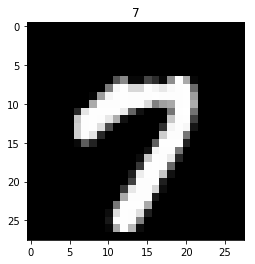

In [67]:
test_label=pd.Series(test_label)
loadimage(test,test_label,89)